In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path= '/content/drive/MyDrive/thesis/code'
os.chdir(path)
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
path = "/workspace"
os.chdir(path)
import sys
!{sys.executable} -m pip install matplotlib pandas seaborn tabulate editdistance nltk transformers sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 KB 12.2 MB/s eta 0:00:00a 0:00:01


In [2]:
import sqlite3
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tabulate import tabulate
import numpy as np
import csv
import torch
import re
import editdistance
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# import metrics
 - Semantic similarity
 - Contradiction
 - Ground Truth (human span):
       1. accuracy
       2. precision
       3. recall

In [3]:
sys.path.append(os.path.abspath(path+'/results'))
from utils import calculate_metrics, semantic_similarity, detect_contradiction

2025-10-15 12:58:37.497855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 12:58:37.512953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760533117.529214   15283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760533117.534371   15283 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760533117.548443   15283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
def evaluate_cf(text, evidences, evidence_ranges, cf):

    word_dist = editdistance.eval(text.split(), cf.split())
    word_dist_percent = word_dist/len(text.split())*100

    evidence_metrics = calculate_metrics(text, evidences, evidence_ranges, cf)
    ev_accuracy = evidence_metrics['accuracy']
    ev_precision = evidence_metrics['precision']
    ev_recall = evidence_metrics['recall']
    ev_f1 = evidence_metrics['f1']

    semantic = semantic_similarity(cf, text)
    contradiction = detect_contradiction(cf, text)

    return {
        "edit_distance": word_dist_percent,
        "evidence_accuracy": ev_accuracy,
        "evidence_precision": ev_precision,
        "evidence_recall": ev_recall,
        "evidence_f1": ev_f1,
        "similarity_metrics": semantic,
        "contradiction": contradiction
    }

# load data

In [5]:
os.chdir(path + '/eraserbenchmark-master')
from rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation
data_root = os.path.join('data', 'esnli')
documents = load_documents(data_root)
test = annotations_from_jsonl(os.path.join(data_root, 'test.jsonl'))
test[:] = [instance for instance in test if instance.classification != 'neutral']

In [6]:
def collect_df(model_name):
    resDf = pd.DataFrame()
    os.chdir(path + f'/introspections/esnli_introspections/{model_name}/results/analysis')
    if model_name[0] == "Q":
        conn = sqlite3.connect(f'analysis_m-qwen_y-none_d-rte_p-test_t-counterfactual_c-_s-0.sqlite')
    else:
        conn = sqlite3.connect(f'analysis_m-llama3_y-none_d-rte_p-test_t-counterfactual_c-_s-0.sqlite')
    cursor = conn.cursor()
    cursor.execute("SELECT explain, correct, faithful FROM Counterfactual;")

    os.chdir(path + '/eraserbenchmark-master/esnli_dataset_builder/my_dataset')
    resDf['texts'] = pd.read_csv("test.csv")['sentence2']

    resDf[['selfexp','correct','faithful']] = pd.DataFrame(cursor.fetchall(), columns=['selfexp','correct','faithful'])
    conn.close()

    resDf['evidences'] = [
        [ev.text
        for ev in next(iter(instance.evidences))
        if '_premise' in ev.docid and ev.docid.endswith('_premise')]
        for instance in test
    ]

    resDf['evidence_ranges'] = [
            [(ev.start_token, ev.end_token)
             for ev in next(iter(instance.evidences))
             if '_premise' in ev.docid and ev.docid.endswith('_premise')]
            for instance in test
        ]

    os.chdir(path)
    csv_files = glob.glob(os.path.join("attacks/esnli_attacks", f"{model_name}*"))

    for file in csv_files:
        df = pd.read_csv(file)
        attack_name = file.split('_')[-1]

        resDf[attack_name] = df.apply(
            lambda row: {
                'perturbed_text': row['perturbed_text'],
                'result_type': row['result_type'],
                'original_score': row['original_score'],
                'perturbed_score': row['perturbed_score']
            },
            axis=1
        )
    return resDf

In [7]:
print('Collecting the data')
print('Llama-3.2-1B-Instruct')
llama1b_df = collect_df('Llama-3.2-1B-Instruct')
print("Llama-3.2-3B-Instruct")
llama3b_df = collect_df('Llama-3.2-3B-Instruct')
print("Meta-Llama-3-8B-Instruct")
llama8b_df = collect_df('Meta-Llama-3-8B-Instruct')
print("Qwen-1.5B")
qwen1b_df = collect_df('Qwen-1.5B')
print("Qwen-3B")
qwen3b_df = collect_df('Qwen-3B')
print("Qwen-7B")
qwen7b_df = collect_df('Qwen-7B')

print("Finished")

Llama-3.2-1B-Instruct
Llama-3.2-3B-Instruct
Meta-Llama-3-8B-Instruct
Qwen-1.5B
Qwen-3B
Qwen-7B
Finished


In [8]:
def display_instance(df, index=0):
    row = df.iloc[index]
    print(f"--- Example Instance from df (Index: {index}) ---\n")
    print(f"Hypothesis: {' '.join(documents[test[index].annotation_id+'_hypothesis'][0])}")
    print(f"Premise: {' '.join(documents[test[index].annotation_id+'_premise'][0])}\n")
    print(f"Original Text (`texts`):\n{row['texts']}\n")
    print(f"Self-explanatory (`selfexp`):\n{row['selfexp']}\n")
    print(f"Correct Label (`correct`): {row['correct']}")
    print(f"Faithful Label (`faithful`): {row['faithful']}\n")
    print(f"Evidences (`evidences`):\n{row['evidences']}\n ranges: {row['evidence_ranges']}\n")
    print(f"TextFooler Adversarial Example (`TextFoolerJin2019.csv`):\n{row['TextFoolerJin2019.csv']}\n")
    print(f"PWWS Adversarial Example (`PWWSRen2019.csv`):\n{row['PWWSRen2019.csv']}\n")
    print("-"*60)

display_instance(llama1b_df, index=0)

--- Example Instance from df (Index: 0) ---

Hypothesis: A woman is smoking a cigarette.
Premise: A man in green pants and blue shirt pushing a cart.

Original Text (`texts`):
A man in green pants and blue shirt pushing a cart.

Self-explanatory (`selfexp`):
A man in green pants and a woman in a blue shirt is walking.

Correct Label (`correct`): 1.0
Faithful Label (`faithful`): 0.0

Evidences (`evidences`):
['man']
 ranges: [(1, 2)]

TextFooler Adversarial Example (`TextFoolerJin2019.csv`):
{'perturbed_text': 'A woman is smoking a cigarette. [[paras]] [[comrade]] in [[verte]] [[robes]] and blue [[gown]] [[press]] a [[railcar]].', 'result_type': 'Failed', 'original_score': 0.2185766696929931, 'perturbed_score': 0.2672018408775329}



KeyError: 'PWWSRen2019.csv'

In [10]:
i = 1000
original_text = qwen1b_df.iloc[i-1]['texts']
evidence_spans = qwen1b_df.iloc[i-1]['evidences']
evidence_ranges = qwen1b_df.iloc[i-1]['evidence_ranges']
perturbed_text = qwen1b_df.iloc[i-1]['TextFoolerJin2019.csv']['perturbed_text'].split('.')[1]

print(original_text)
print(perturbed_text)
print(evidence_spans)
print(evidence_ranges)

calculate_metrics(original_text, evidence_spans, evidence_ranges, perturbed_text)
print(editdistance.eval(original_text.split(), perturbed_text.split()))

A young woman in a bikini looking at something in a glass case.
 [[paras]] [[younger]] [[gal]] in a [[bare]] [[striving]] at something in a [[crystals]] [[cas]]
['bikini']
[(5, 6)]
7


# Evaluation

In [11]:
def evaluate_df(df):
    results = []
    attack_columns = [col for col in df.columns if col not in ['texts', 'selfexp', 'evidence_ranges','evidences','correct','faithful']]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for index, row in df.iterrows():     #counterfactuals evaluation
        print(index, end="\r", flush=True)
        row['evidences'][:] = [ev for ev in row['evidences'] if ev in row['texts']]

        row_result = {}
        if row['selfexp'] is not None:
            row_result['selfexp'] = evaluate_cf(row['texts'], row['evidences'], row['evidence_ranges'], row['selfexp'])

        for attack_col in attack_columns:
            attacked_text = row[attack_col]['perturbed_text'].split('.')[1]
            row_result[attack_col] = evaluate_cf(row['texts'], row['evidences'], row['evidence_ranges'], re.sub(r"\[\[(.*?)\]\]", lambda m: m.group(1), attacked_text))

        results.append(row_result)

    attack_summaries = {}     #attack stats
    total = 0
    faithful = 0
    for index, row in df.iterrows():
        total += 1
        faithful += int(row['faithful'] if not pd.isna(row['faithful']) else 0)

    attack_summaries["Introspection"] = {
        'successful': faithful,
        'total': total,
    }

    for attack_col in attack_columns:
        successful = 0
        total = 0
        for index, row in df.iterrows():
            total += 1
            if row[attack_col]['result_type'] == 'Successful':
                successful += 1

        attack_summaries[attack_col] = {
            'successful': successful,
            'total': total,
        }

    return pd.DataFrame(results), attack_summaries

In [12]:
print("Evaluation")
print('Llama-3.2-1B-Instruct')
llama_1b_res, llama_1b_attack_res = evaluate_df(llama1b_df)
print("Llama-3.2-3B-Instruct")
llama_3b_res, llama_3b_attack_res = evaluate_df(llama3b_df)
print("Meta-Llama-3-8B-Instruct")
llama_8b_res, llama_8b_attack_res = evaluate_df(llama8b_df)
print("Qwen-1.5B")
qwen_1b_res, qwen_1b_attack_res = evaluate_df(qwen1b_df)
print("Qwen-3B")
qwen_3b_res, qwen_3b_attack_res = evaluate_df(qwen3b_df)
print("Qwen-7B")
qwen_7b_res, qwen_7b_attack_res = evaluate_df(qwen7b_df)
print("Finished")

Evaluation
Llama-3.2-1B-Instruct
0

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Llama-3.2-3B-Instruct
Meta-Llama-3-8B-Instruct
Qwen-1.5B
Qwen-3B
Qwen-7B
Finished


# plotting

In [13]:
from utils import plot_attack_comparison, plot_size_comparison

In [14]:
def extract_means(df):
    flattened = pd.json_normalize(df.apply(lambda x: x.to_dict(), axis=1))
    return {
        'edit_distance': {col: flattened[col].mean() for col in flattened if 'edit_distance' in col},
        'semantic_similarity': {col: flattened[col].mean() for col in flattened if 'similarity' in col},
        'contradiction': {col: flattened[col].mean() for col in flattened if 'contradiction' in col},
        'evidence_accuracy': {col: flattened[col].mean() for col in flattened if 'evidence_accuracy' in col},
        'evidence_precision': {col: flattened[col].mean() for col in flattened if 'evidence_precision' in col},
        'evidence_recall': {col: flattened[col].mean() for col in flattened if 'evidence_recall' in col},
        'evidence_f1': {col: flattened[col].mean() for col in flattened if 'evidence_f1' in col},
    }

# Introspection - Attack Evaluation
**Success rate**: the percentage of input instances for which the model was able to generate a faithful counterfactual — a perturbed version of the input that leads the model to predict the opposite label compared to the original classification.

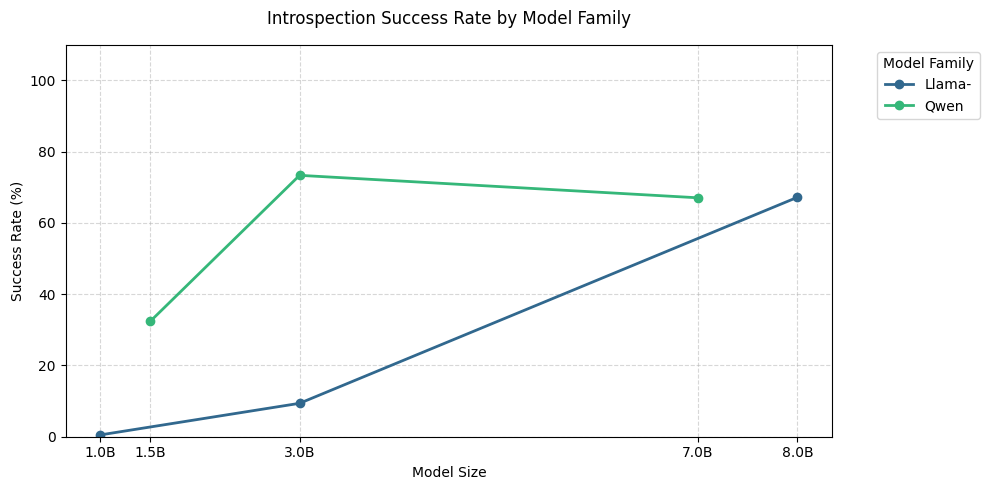

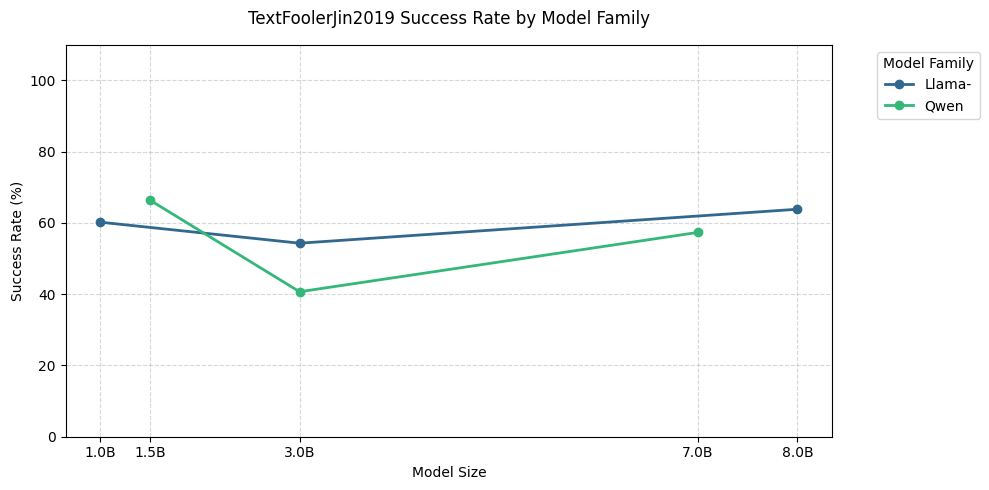

In [15]:
all_attack_data = {
    "Llama-3.2-1B-Instruct": llama_1b_attack_res,
    "Llama-3.2-3B-Instruct": llama_3b_attack_res,
    "Llama-3-8B-Instruct": llama_8b_attack_res,
    "Qwen2.5-1.5B": qwen_1b_attack_res,
    "Qwen2.5-3B": qwen_3b_attack_res,
    "Qwen2.5-7B": qwen_7b_attack_res,
}

directory = path+'/results/esnli_results'
plot_attack_comparison(all_attack_data, directory, cmap="viridis")

# Counterfactual Evaluation Metrics

## 📊 Core Definitions

- **Positive**: A token from the original text that was changed (according to each attack/introspection)
- **Negative**: A token from the original text that was not changed
- **True Positive (TP)**: A changed token that overlaps with at least one evidence span ✅
- **False Positive (FP)**: A changed token that does NOT overlap with any evidence span ❌  
- **False Negative (FN)**: An evidence span that doesn't overlap with any detected change ❌
- **True Negative (TN)**: A token that was not changed and is not in any evidence span ✅

---

## 📈 Metrics

### Accuracy
*Overall, what percentage of tokens were correctly classified?*
```python
Accuracy = (TP + TN) / Total_Tokens if Total_Tokens > 0 else 0
```
**True Negatives take over**

### Precision
*Of all the changes detected, what percentage were actually evidence-supported changes?*

```python
Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
```
### Recall

*Of all the evidence spans, what percentage were successfully detected as changes?*

```python
Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
```

### F1 Score

*Harmonic mean of precision and recall*

```python
F1 = 2 * Precision * Recall / (Precision + Recall) if (Precision + Recall) > 0 else 0
```


### Polyjuice recall

*Of all the changes made, what percentage corresponds to words that Polyjuice modified too?*

```python
pj_precision = len( polyjuice_changes_set & attack_changes_set ) / len( attack_changes_set )
```


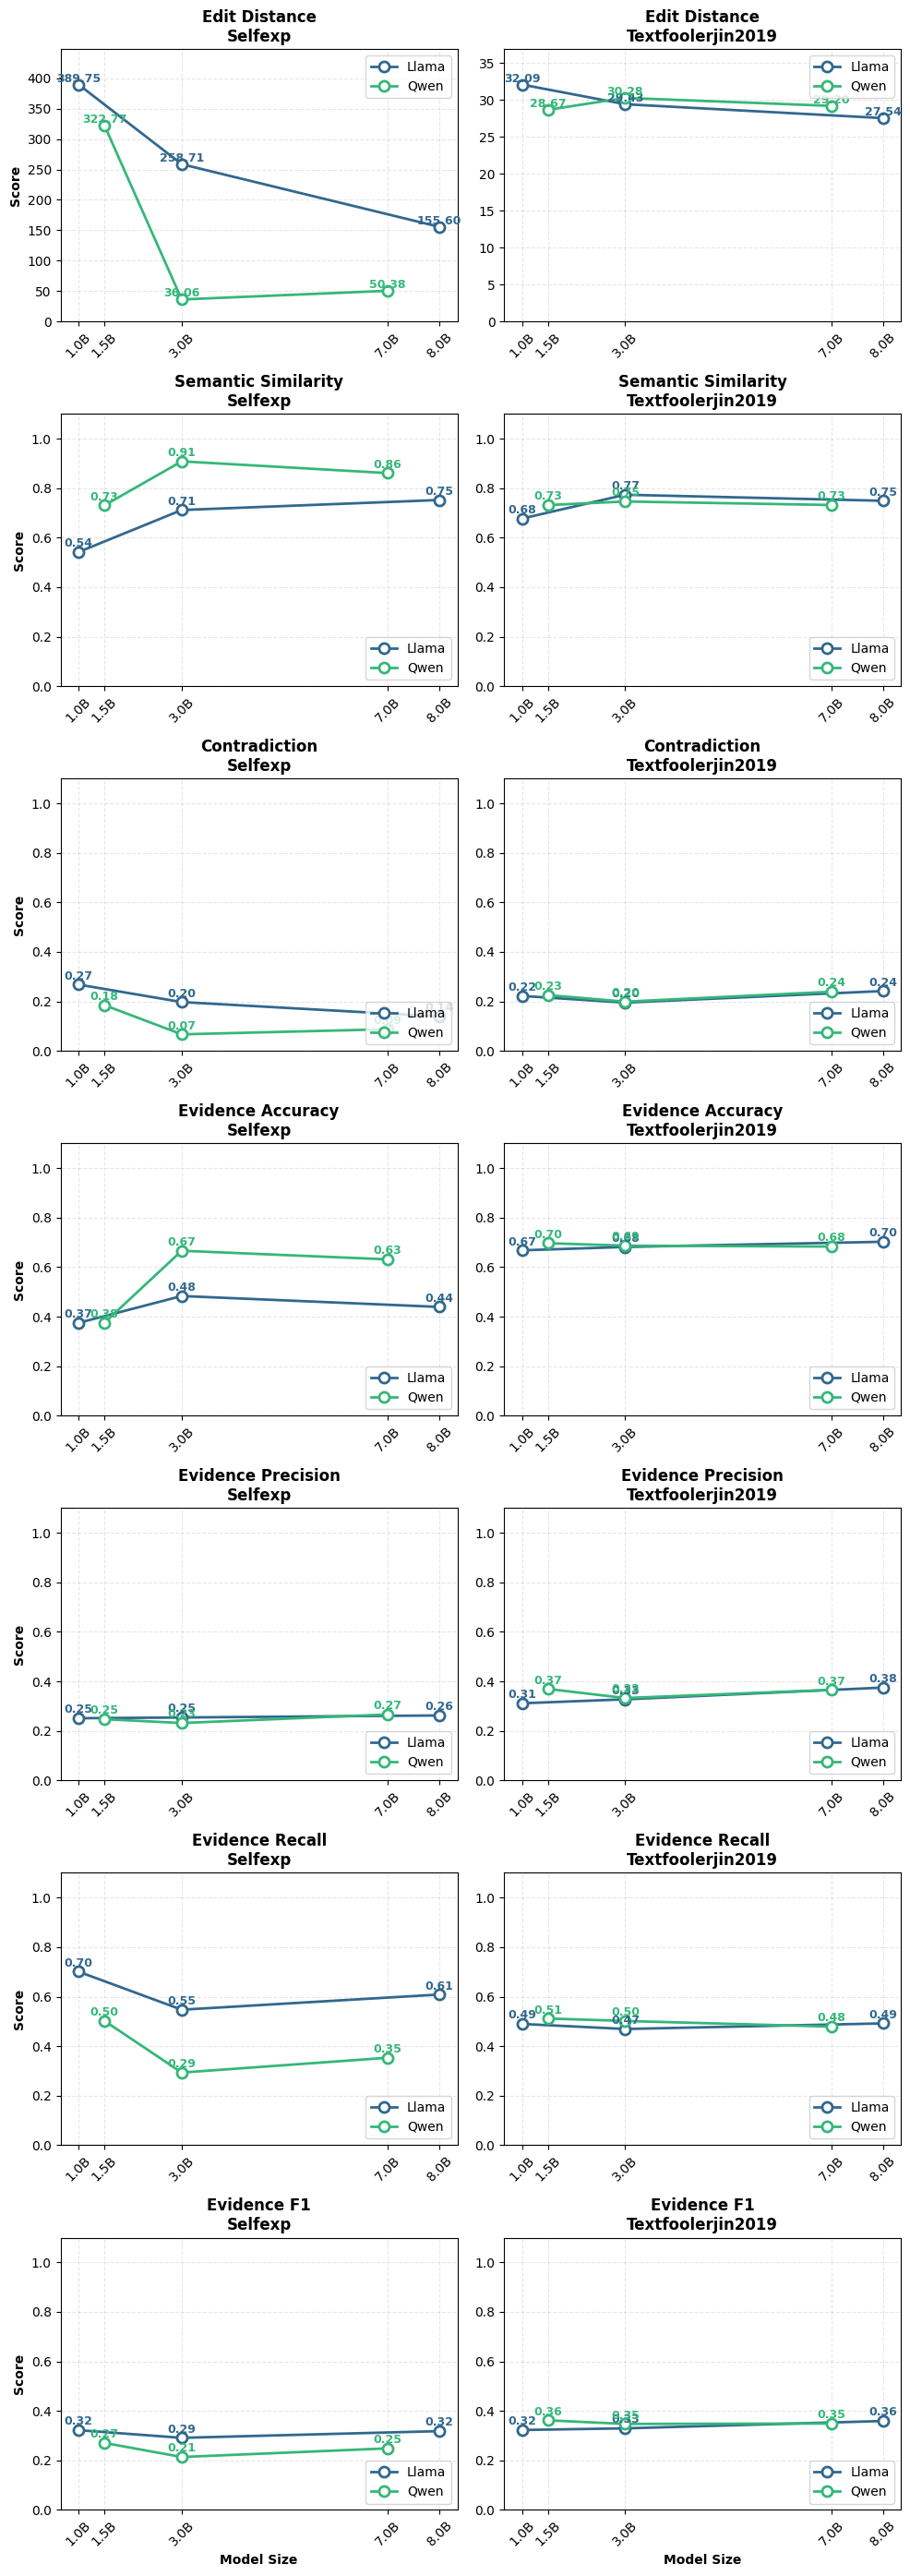

In [16]:
result_dataframes = {
    "Llama-3.2-1B-Instruct": llama_1b_res,
    "Llama-3.2-3B-Instruct": llama_3b_res,
    "Meta-Llama-3-8B-Instruct": llama_8b_res,
    "Qwen2.5-1.5B": qwen_1b_res,
    "Qwen2.5-3B": qwen_3b_res,
    "Qwen2.5-7B": qwen_7b_res,
}

directory = path+'/results/esnli_results'
plot_size_comparison(result_dataframes, extract_means, directory, "viridis")

### Recall Between Methods

The **proportion of tokens changed by method *i*** that were also changed by method *j*.

- `Ti`: the set of original tokens changed by method *i*
- `Tj`: the set of original tokens changed by method *j*


$$
\text{Recall}(i, j) = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} = \frac{|T_i \cap T_j|}{|T_j|}
$$

In [19]:
from difflib import SequenceMatcher

def recall(set_small, set_large):
    if not set_large:
        return 0.0
    return len(set_small & set_large) / len(set_large)

def get_changed_tokens(original, counterfactual):
    orig_tokens = original.split()
    if counterfactual:
        cf_tokens = counterfactual.split()
    else:
        return set()
    matcher = SequenceMatcher(None, orig_tokens, cf_tokens)
    changed = set()
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag in ['replace', 'delete']:
            changed.update(orig_tokens[i1:i2])
    return changed

def calculate_model_method_heatmap(models, collect_fn):
    methods = ['selfexp', 'TextFoolerJin2019.csv']
    all_variants = []  # [(model, method)]
    token_changes = {}  # key: (model, method) → list of changed token sets

    for method in methods:
        for model in models:
            df = collect_fn(model)
            key = (model, method)
            all_variants.append(key)
            token_changes[key] = []
            for _, row in df.iterrows():
                original = row['texts']
                if method == 'selfexp':
                    cf = row[method]
                else:
                    cf = row[method]['perturbed_text']
                changed = get_changed_tokens(original, cf)
                token_changes[key].append(changed)

    # Create similarity matrix
    n = len(all_variants)
    similarity_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            key1 = all_variants[i]
            key2 = all_variants[j]
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                jaccard_scores = [
                    recall(token_changes[key1][k], token_changes[key2][k])
                    for k in range(len(token_changes[key1]))
                ]
                similarity_matrix[i][j] = np.mean(jaccard_scores)

    # Labeling
    labels = [f"{model.replace('-Instruct','')} / {method.split('.')[0]}" for model, method in all_variants]

    # Plot
    df_sim = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
    plt.figure(figsize=(14, 12))
    sns.heatmap(df_sim, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
    plt.title("Recall Across " +  model.split("-")[0] +" Models & Methods", fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    os.chdir(path + '/results/esnli_results')
    plt.savefig("heatmap_" + model.split("-")[0] + ".png", dpi=300)
    plt.show()

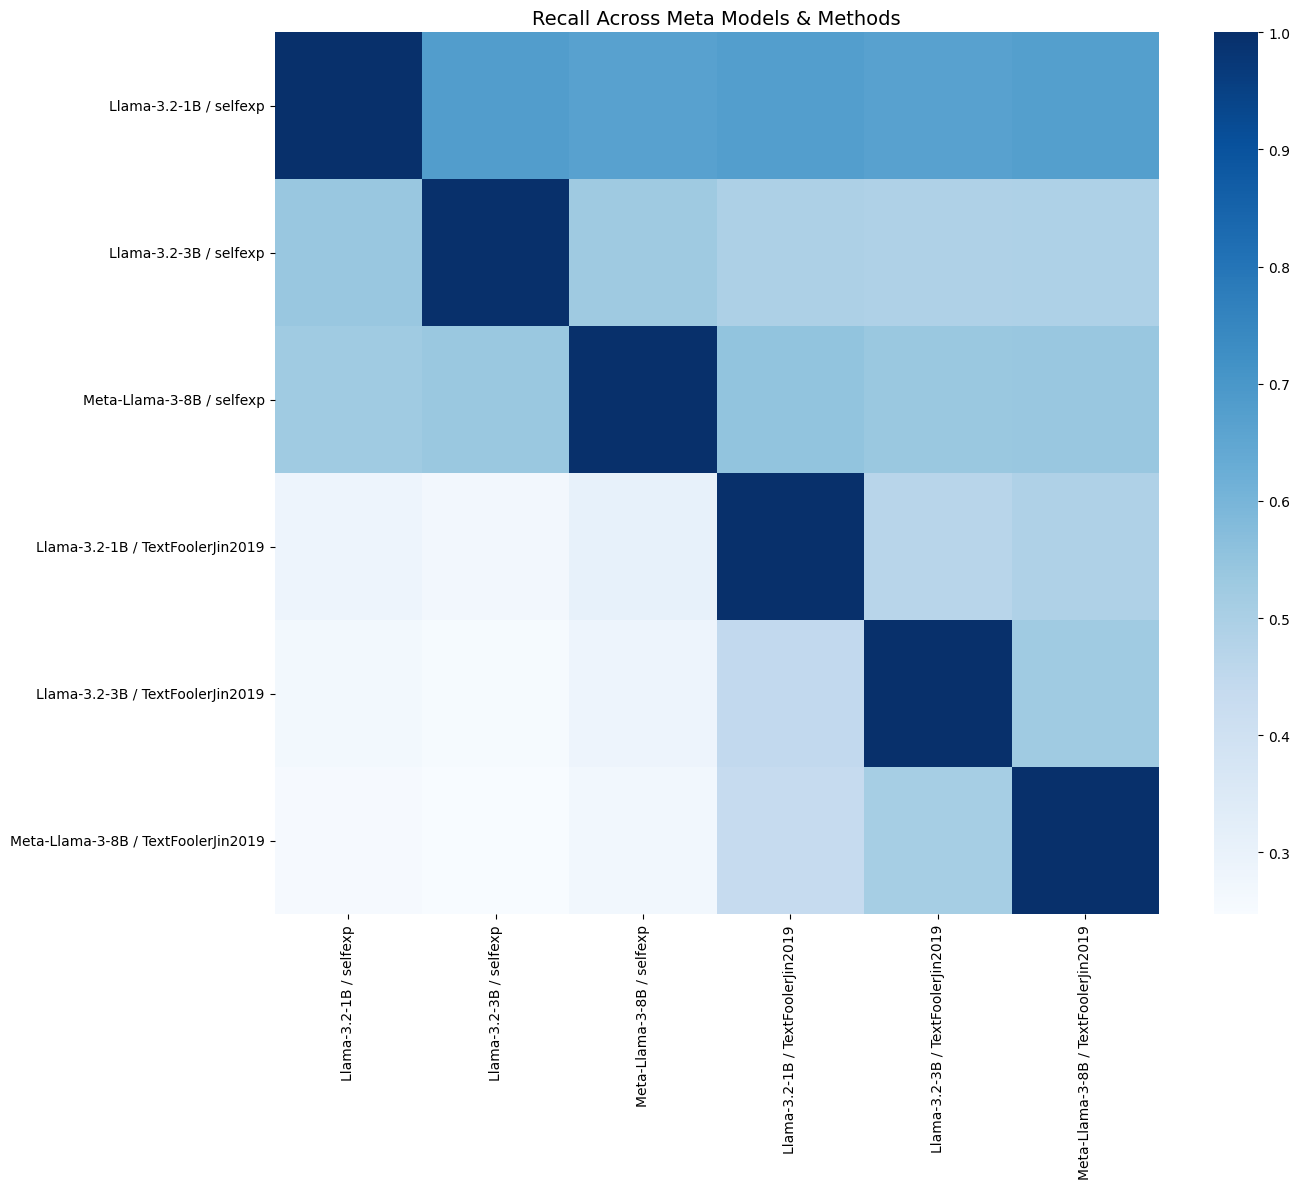

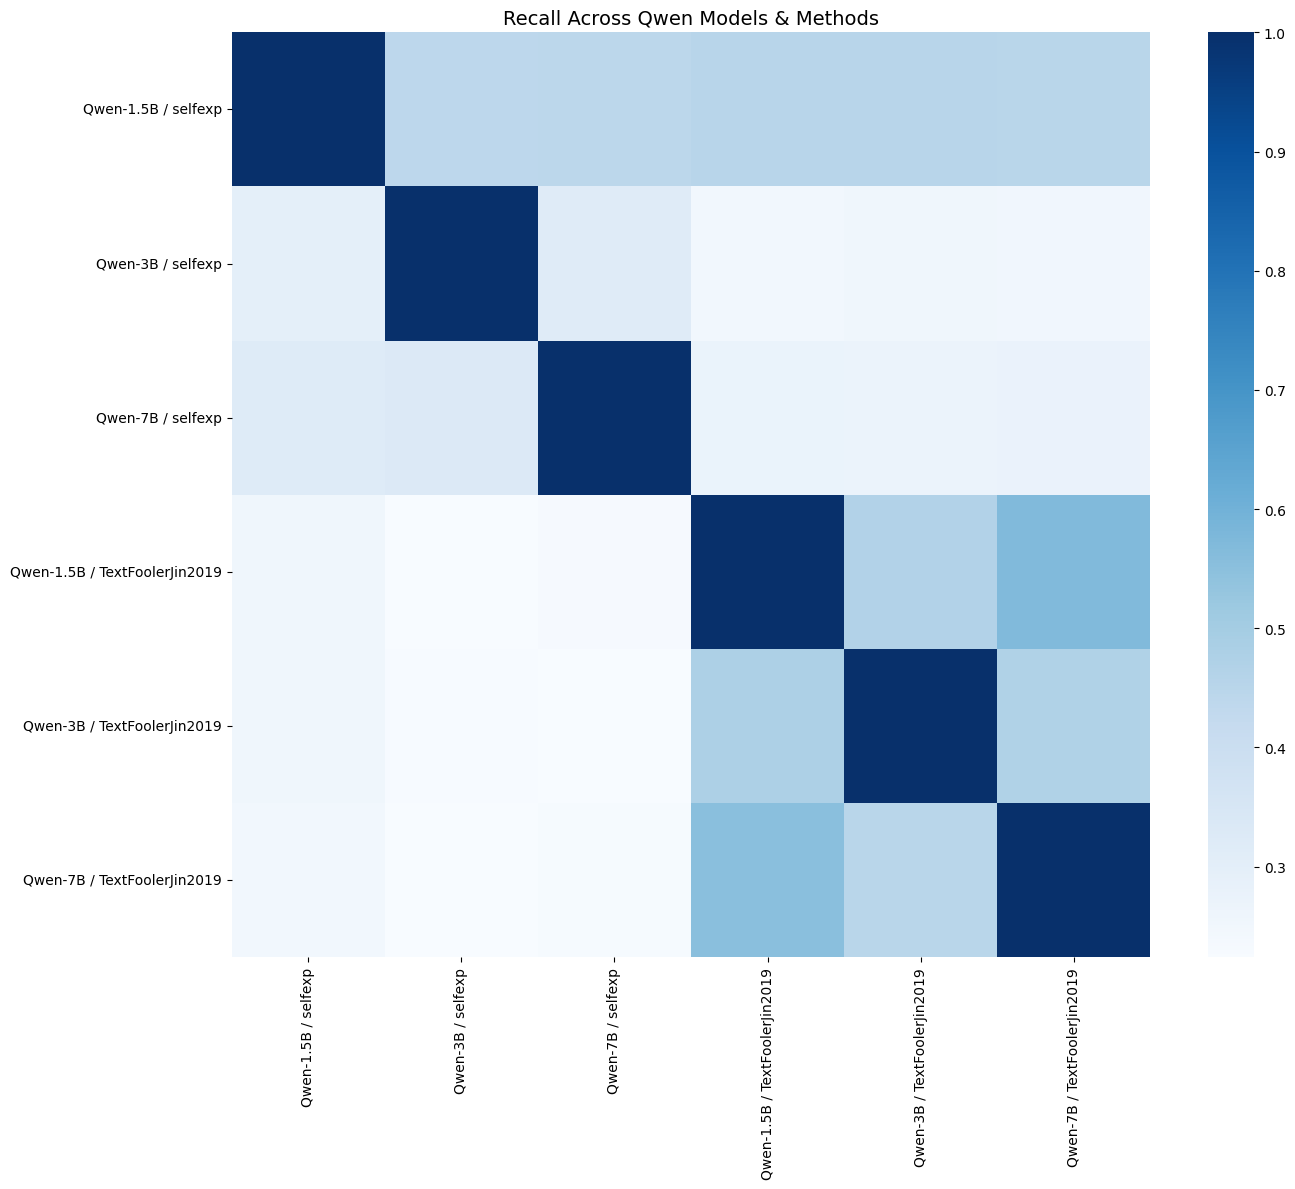

In [20]:
llama_models = ['Llama-3.2-1B-Instruct', "Llama-3.2-3B-Instruct", "Meta-Llama-3-8B-Instruct"]
qwen_models = ["Qwen-1.5B", "Qwen-3B", "Qwen-7B"]
calculate_model_method_heatmap(llama_models,collect_df)
calculate_model_method_heatmap(qwen_models,collect_df)

### Παρατηρήσεις

 - Οι adversarial επιθέσεις σταθερά αλλάζουν tokens τα οποία έχουν αλλαχθεί και στα self-explanations.

 - Μέτρια έως χαμηλή συμφωνία μεταξύ των διαφορετικών adversarial επιθέσεων.

 - όσο μεγαλύτερο είναι το recall μεταξύ attacks και self-explanations, τόσο μικρότερη είναι η συμφωνία μεταξύ των ίδιων των attack μεθόδων.